# VAE
inspired by 

https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb

https://github.com/timbmg/VAE-CVAE-MNIST

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.utils

## Hyperparamters

In [2]:
latent_dims = 8
num_epochs = 100
batch_size = 128
channel = 64
learning_rate = 1e-3
variational_beta = 1
cuda_device = "cuda:1" 

## Loading MNIST

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## VAE model

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = channel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = channel
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), channel*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device(cuda_device if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 421265


## Training

In [5]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 19170.701586
Epoch [2 / 100] average reconstruction error: 15524.742704
Epoch [3 / 100] average reconstruction error: 14998.079310
Epoch [4 / 100] average reconstruction error: 14680.825610
Epoch [5 / 100] average reconstruction error: 14466.263320
Epoch [6 / 100] average reconstruction error: 14312.514740
Epoch [7 / 100] average reconstruction error: 14192.935143
Epoch [8 / 100] average reconstruction error: 14101.537170
Epoch [9 / 100] average reconstruction error: 14026.372555
Epoch [10 / 100] average reconstruction error: 13959.334490
Epoch [11 / 100] average reconstruction error: 13899.223379
Epoch [12 / 100] average reconstruction error: 13853.146349
Epoch [13 / 100] average reconstruction error: 13804.070610
Epoch [14 / 100] average reconstruction error: 13769.589531
Epoch [15 / 100] average reconstruction error: 13733.645676
Epoch [16 / 100] average reconstruction error: 13701.119176
Epoch [17 / 100] average reconstruct

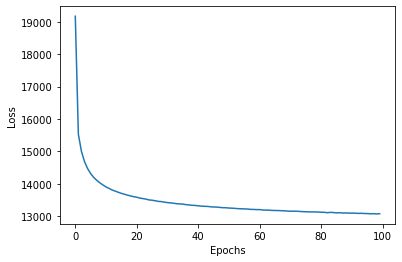

In [6]:
## trainign curve
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [7]:
# test set error
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 12798.156822


## Visulazation

### test set

Original images


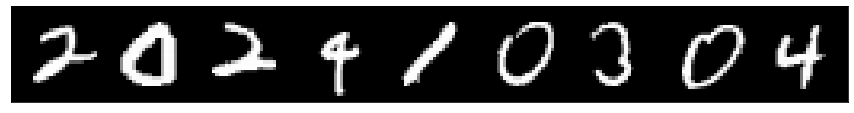

VAE reconstruction:


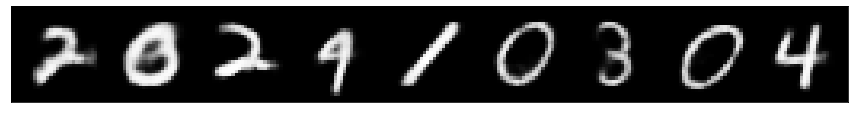

In [8]:
vae.eval()

SAMPLES = 10

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    plt.figure(figsize=(15, 5))
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # rearange to (H,W,C)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid

def visualize_output(images, model,samples=SAMPLES):

    with torch.no_grad():
    
        images = images.to(device)
        images, latent_mu, latent_logvar = (element.cpu() for element in model(images))
        images = to_img(images) 
        np_imagegrid = torchvision.utils.make_grid(images[1:samples], samples, 1).numpy()

        plt.figure(figsize=(15, 5))
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.xticks([]) # to remove x-axis  the [] empty list indicates this
        plt.yticks([]) # to remove y-axis
        plt.grid(False) # to remove grid
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualize the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:SAMPLES],SAMPLES,1))
plt.show()

# Reconstruct and visualize the images using the vae
print('VAE reconstruction:')
visualize_output(images, vae)

### Sample Latent Variables from Prior (VAE as Generator)

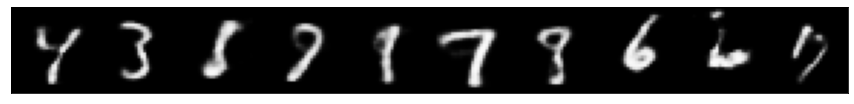

In [9]:
vae.eval()

SAMPLES = 10

with torch.no_grad():

    # sample latent vectors from the normal distribution (prior)
    latent = torch.randn(SAMPLES, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    show_image(torchvision.utils.make_grid(img_recon.data[:SAMPLES],SAMPLES,1))
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.show()
    plt.show()